<a href="https://colab.research.google.com/github/gauravsharma2/A6---defect-prediction/blob/main/Mushroom_images_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import zipfile
import os

zip_path = '/content/sample_data/Mushrooms.zip'
extract_dir = '/content/sample_data/Mushrooms'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted all files to {extract_dir}")

image_dir = '/content/sample_data/Mushrooms/Mushrooms/'   # <-- change this to wherever your images are

# 2. Grab all the .jpg/.png files
image_paths = [
    os.path.join(image_dir, fname)
    for fname in os.listdir(image_dir)
    if fname.lower().endswith(('.jpg', '.jpeg', '.png'))
]
print(f"Found {len(image_paths)} images.")

# 3. (Optional) display the first few
for path in image_paths[:5]:
    img = Image.open(path)
    plt.imshow(img); plt.axis('off')
    plt.show()

Extracted all files to /content/sample_data/Mushrooms
Found 0 images.


# Neural network classifier for mushrooms

In [42]:
import os
import shutil
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth

In [43]:
# To fix "Image File is truncated" error during training
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [45]:
# Settings for displaying charts
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 12})

In [46]:
physical_devices = list_physical_devices('GPU')
print(f'Number of GPUs available: {len(physical_devices)}')

if len(physical_devices) > 0:
    set_memory_growth(physical_devices[0], True)

Number of GPUs available: 1


In [47]:
# TensorFlow settings
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMG_SIZE = 299
BATCH_SIZE = 64

## Loading and processing data

In [48]:
# Path to the folder with 9 classes of images:
data_path = '/content/sample_data/Mushrooms/Mushrooms'

In [48]:
history = new_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    steps_per_epoch=79,    # 5033 / 64 ≈ 79
    validation_steps=16,   # 1005 / 64 ≈ 16
    verbose=2,
    callbacks=[reduce_lr, early_stop]
)


In [49]:
import os
import shutil
import random

# 1. Point this at your extracted images root:
data_path = '/content/sample_data/Mushrooms/Mushrooms'

# 2. Where to dump train/val/test
output_base = '/content/sample_data/temp'
splits       = {'train': 0.75, 'valid': 0.15, 'test': 0.10}

# 3. Create empty class subfolders in each split dir:
for split_name in splits:
    for class_name in os.listdir(data_path):
        class_src = os.path.join(data_path, class_name)
        if not os.path.isdir(class_src):
            continue
        dst_dir = os.path.join(output_base, split_name, class_name)
        os.makedirs(dst_dir, exist_ok=True)

# 4. For each class, shuffle & copy the right % into each split:
for class_name in os.listdir(data_path):
    class_src = os.path.join(data_path, class_name)
    if not os.path.isdir(class_src):
        continue

    # get only files (no nested directories):
    all_files = [
        f for f in os.listdir(class_src)
        if os.path.isfile(os.path.join(class_src, f))
    ]
    random.shuffle(all_files)

    n = len(all_files)
    n_train = int(n * splits['train'])
    n_valid = int(n * splits['valid'])
    # rest goes to test
    train_files = all_files[:n_train]
    valid_files = all_files[n_train:n_train + n_valid]
    test_files  = all_files[n_train + n_valid:]

    # helper to copy:
    def copy_list(file_list, split_name):
        dst_dir = os.path.join(output_base, split_name, class_name)
        for fname in file_list:
            src_file = os.path.join(class_src, fname)
            dst_file = os.path.join(dst_dir,   fname)
            shutil.copy2(src_file, dst_file)

    copy_list(train_files, 'train')
    copy_list(valid_files, 'valid')
    copy_list(test_files,  'test')

print("Done!  Train/Valid/Test in:", output_base)


Done!  Train/Valid/Test in: /content/sample_data/temp


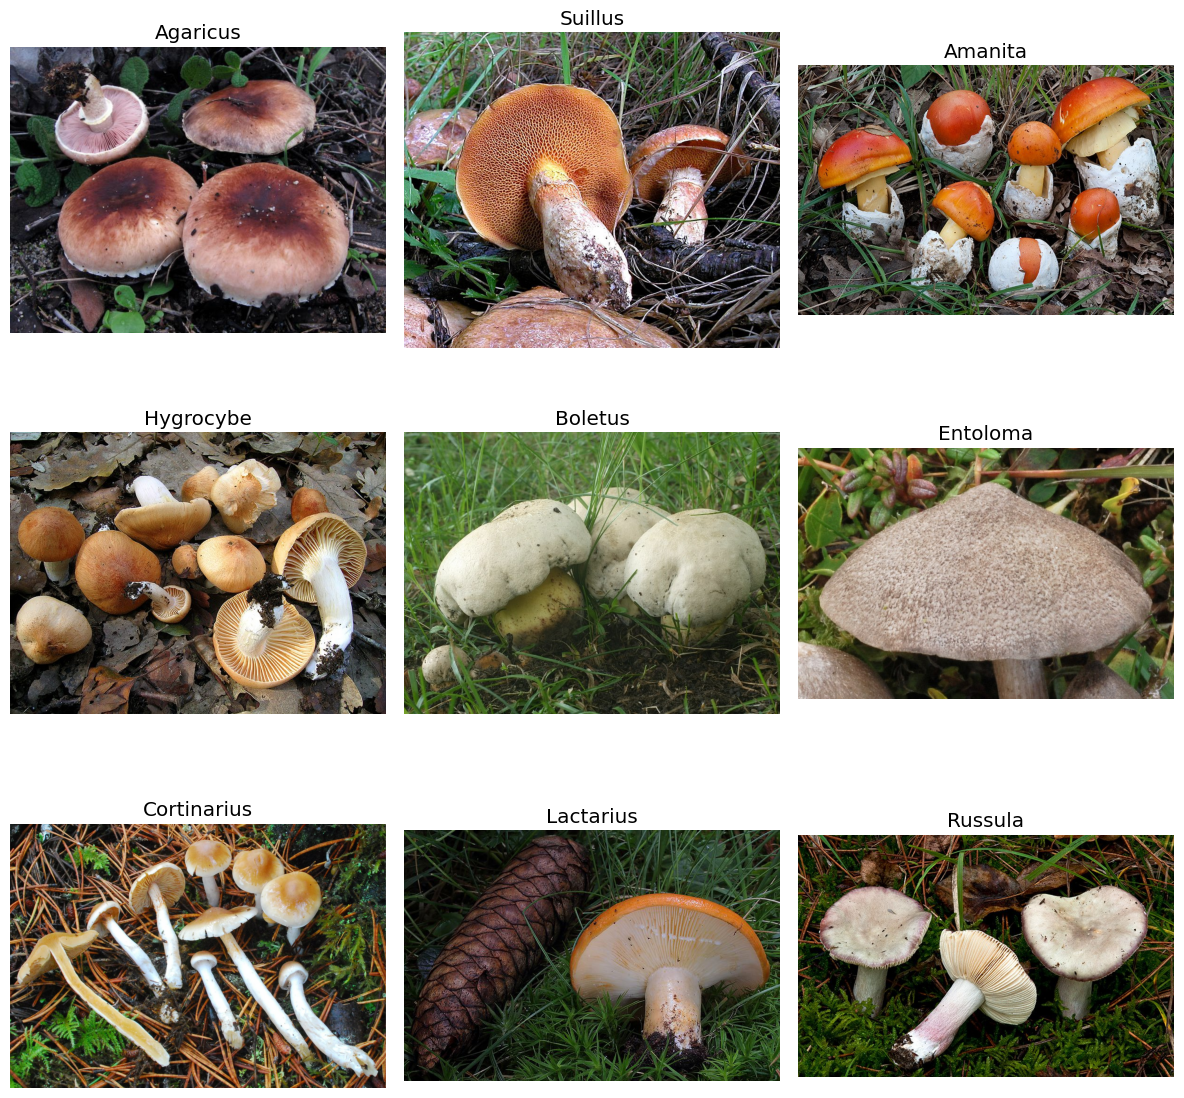

In [50]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_path = '/content/sample_data/Mushrooms/Mushrooms'

# only keep true class-dirs
class_dirs = [
    d for d in os.listdir(data_path)
    if os.path.isdir(os.path.join(data_path, d))
]

nrows, ncols = 3, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
axes = axes.flatten()

for ax, class_name in zip(axes, class_dirs):
    class_dir = os.path.join(data_path, class_name)
    # get only image files
    img_files = [
        f for f in os.listdir(class_dir)
        if os.path.isfile(os.path.join(class_dir, f))
           and f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    if not img_files:
        ax.axis('off')
        continue

    img_path = os.path.join(class_dir, img_files[0])
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [51]:
# Create image datasets
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/sample_data/temp/train',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
valid_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/sample_data/temp/valid',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)\
                    .flow_from_directory(directory='/content/sample_data/temp/test',
                                         target_size=(IMG_SIZE, IMG_SIZE),
                                         class_mode='categorical',
                                         batch_size=BATCH_SIZE,
                                         shuffle=False)

Found 6313 images belonging to 10 classes.
Found 1867 images belonging to 9 classes.
Found 1289 images belonging to 9 classes.


## Creating a model

In [52]:
# Pretrained EfficientNetB7 image classification model without final layers
feature_model = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                     pooling='avg')

feature_model.summary()

Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 299, 299,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 299, 299,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 299, 299,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 63,786,960 (243.33 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [53]:
# Construct a new model with the final dense layer for 9 classes
new_model = tf.keras.models.Sequential(
    [
        feature_model,
        tf.keras.layers.Dense(9, activation='softmax')
    ]
)

In [54]:
# Make all the layers from the original ResNet model untrainable
new_model.layers[0].trainable = False

In [55]:
# Metrics and optimizer
new_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [56]:
# Check the architecture of the new model
new_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │        23,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,120,736 (244.60 MB)

 Trainable params: 23,049 (90.04 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

In [57]:
# Callbacks to be exercised during training
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=10,
                                              restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                 factor=0.1,
                                                 mode='max',
                                                 cooldown=2,
                                                 patience=2,
                                                 min_lr=0)

In [59]:
# 1. Inspect how many classes your generator found
num_classes = train_generator.num_classes
print("Found", num_classes, "classes:", train_generator.class_indices)

# 2. Rebuild your model’s top to match that
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# assume `base` is your pretrained feature-extractor
x = base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
# ← here’s the change: use num_classes instead of hard-coding 9
predictions = Dense(num_classes, activation='softmax')(x)

new_model = Model(inputs=base.input, outputs=predictions)
new_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Now fit exactly as before (dropping the unsupported args if you’re on a tf.data pipeline)
history = new_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=100,
    steps_per_epoch=79,    # 5033/64 ≈ 79
    validation_steps=16,   # 1005/64 ≈ 16
    verbose=2,
    callbacks=[reduce_lr, early_stop]
)


Found 10 classes: {'.ipynb_checkpoints': 0, 'Agaricus': 1, 'Amanita': 2, 'Boletus': 3, 'Cortinarius': 4, 'Entoloma': 5, 'Hygrocybe': 6, 'Lactarius': 7, 'Russula': 8, 'Suillus': 9}


NameError: name 'base' is not defined

# Displaying the results

In [ ]:
loss, accuracy = new_model.evaluate(test_generator,
                                    steps=11,
                                    verbose=2,
                                    use_multiprocessing=True,
                                    workers=2)
print(f'Model performance on test images:\nAccuracy = {accuracy}\nLoss = {loss}')

In [ ]:
# Loss during training:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot();

In [ ]:
# Accuracy during training:
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

nb_samples = 676 # number of test images
Y_pred = new_model.predict_generator(test_generator, nb_samples // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
# x is true class, y is predicted class-- middle diagonal represents the accurate predictions

In [ ]:
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [67]:
# -*- coding: utf-8 -*-
"""Mushroom Image Classification (Refactored)

This script unzips the dataset (if needed), sets up train/validation loaders
with a built-in split to guarantee matching classes, builds a dynamic model head,
trains with live progress reporting (including validation metrics), and saves
 the best model for reuse.
"""
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.python.framework.config import list_physical_devices, set_memory_growth
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import ImageFile

# Fix truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Enable GPU memory growth
gpus = list_physical_devices('GPU')
if gpus:
    set_memory_growth(gpus[0], True)

# Paths & params
RAW_DIR    = '/content/sample_data/Mushrooms/Mushrooms'   # top-level class folders
IMG_SIZE   = 299
BATCH_SIZE = 64
MODEL_PATH = '/content/mushroom_classifier.h5'
EPOCHS     = 10
VAL_SPLIT  = 0.15

# 1. (Optional) Unzip dataset if ZIP present
zipfile_path = '/content/sample_data/Mushrooms.zip'
if os.path.exists(zipfile_path):
    with zipfile.ZipFile(zipfile_path, 'r') as z:
        z.extractall(os.path.dirname(RAW_DIR))

# 2. Build generators with an internal train/val split
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT
)

train_loader = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
valid_loader = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# 3. Dynamic model construction
num_classes = train_loader.num_classes
print(f"Found {num_classes} classes: {train_loader.class_indices}")

base = EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling='avg'
)
base.trainable = False

model = Sequential([
    base,
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 4. Callbacks: early stop, LR reduce, checkpoint
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                      patience=2, cooldown=2, min_lr=1e-6),
    ModelCheckpoint(MODEL_PATH, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# 5. Train with live progress
history = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# 6. Save final weights (if different from best)
model.save(MODEL_PATH)
print(f"Best model saved to {MODEL_PATH}")

# 7. To reload later:
# from tensorflow.keras.models import load_model
# model = load_model(MODEL_PATH)


Found 5712 images belonging to 9 classes.
Found 1002 images belonging to 9 classes.
Found 9 classes: {'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 2560)           │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,413,536 (249.53 MB)

 Trainable params: 1,315,849 (5.02 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5508 - loss: 1.2692
Epoch 1: val_accuracy improved from -inf to 0.73054, saving model to /content/mushroom_classifier.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.5518 - loss: 1.2663 - val_accuracy: 0.7305 - val_loss: 0.7725 - learning_rate: 0.0010
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.7953 - loss: 0.6229
Epoch 2: val_accuracy improved from 0.73054 to 0.74751, saving model to /content/mushroom_classifier.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7952 - loss: 0.6229 - val_accuracy: 0.7475 - val_loss: 0.7049 - learning_rate: 0.0010
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.8196 - loss: 0.5271
Epoch 3: val_accuracy did not improve from 0.74751
90/90 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8197 - loss: 0.5269 - val_accuracy: 0.7405 - val_loss: 0.7177 - learning_rate: 0.0010
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.8464 - loss: 0.4506
Epoch 4: val_accuracy improved from 0.74751 to 0.78743, saving model to /content/mushroom_classifier.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8465 - loss: 0.4505 - val_accuracy: 0.7874 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - accuracy: 0.8751 - loss: 0.3759
Epoch 5: val_accuracy did not improve from 0.78743
90/90 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8751 - loss: 0.3758 - val_accuracy: 0.7874 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.8927 - loss: 0.3128
Epoch 6: val_accuracy improved from 0.78743 to 0.79341, saving model to /content/mushroom_classifier.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8925 - loss: 0.3132 - val_accuracy: 0.7934 - val_loss: 0.6472 - learning_rate: 0.0010
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 991ms/step - accuracy: 0.8858 - loss: 0.3139
Epoch 7: val_accuracy did not improve from 0.79341
90/90 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8859 - loss: 0.3139 - val_accuracy: 0.7814 - val_loss: 0.6090 - learning_rate: 0.0010
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.9172 - loss: 0.2507
Epoch 8: val_accuracy improved from 0.79341 to 0.81038, saving model to /content/mushroom_classifier.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.9172 - loss: 0.2507 - val_accuracy: 0.8104 - val_loss: 0.6207 - learning_rate: 0.0010
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - accuracy: 0.9283 - loss: 0.2184
Epoch 9: val_accuracy did not improve from 0.81038
90/90 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9283 - loss: 0.2185 - val_accuracy: 0.8074 - val_loss: 0.5951 - learning_rate: 0.0010
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9383 - loss: 0.1962
Epoch 10: val_accuracy improved from 0.81038 to 0.81836, saving model to /content/mushroom_classifier.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9383 - loss: 0.1963 - val_accuracy: 0.8184 - val_loss: 0.5807 - learning_rate: 0.0010


Best model saved to /content/mushroom_classifier.h5


In [70]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Same constants you used in training
IMG_SIZE   = 299
BATCH_SIZE = 64

# 1) Load & re-compile the saved model so metrics are built
model = load_model('/content/mushroom_classifier.h5')
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 2) Point at the correct test folder
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_loader = test_datagen.flow_from_directory(
    '/content/sample_data/temp/test',  # <- correct path
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3) Run evaluation
loss, acc = model.evaluate(
    test_loader,
    steps=test_loader.samples // test_loader.batch_size,
    verbose=1
)
print(f"Test loss: {loss:.4f} — Test accuracy: {acc:.4f}")


Found 2781 images belonging to 9 classes.
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.8817 - loss: 0.3448
Test loss: 0.3684 — Test accuracy: 0.8714


In [72]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Make sure these match what you used for training
IMG_SIZE = 299

# 1) Your saved model
model = load_model('/content/mushroom_classifier.h5')

# 2) Rebuild the index→class mapping from your train_loader
idx_to_class = {v:k for k,v in train_loader.class_indices.items()}

# 3) Paths to your 3 images
img_paths = [
    '/content/sample_data/test/test1.jpg',
    '/content/sample_data/test/test2.jpg',
    '/content/sample_data/test/test3.jpg',
]

for img_path in img_paths:
    # load & preprocess just like in your generator
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    x   = preprocess_input(x)

    # predict
    probs    = model.predict(x)[0]                # shape (num_classes,)
    pred_idx = np.argmax(probs)                   # integer index
    label    = idx_to_class[pred_idx]             # human-readable class
    conf     = probs[pred_idx]

    print(f"{os.path.basename(img_path):20s} → {label:12s}  (conf={conf:.2f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
test1.jpg            → Amanita       (conf=0.97)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
test2.jpg            → Amanita       (conf=0.98)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
test3.jpg            → Boletus       (conf=0.43)
